# Package loading

In [117]:
import numpy as np
import pandas as pd
import os
import shapely
from shapely.geometry.point import Point
from shapely.geometry import Polygon
import dxfgrabber as dxfgb
import matplotlib.pyplot as plt
import math

# Package documentation

http://dxfgrabber.readthedocs.io/en/latest/  
https://shapely.readthedocs.io/en/latest/

# DXF loading

In [596]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample', 'DXF')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]
dxflist

['/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/K8035200_1 - copie.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/K8035200_1 2 - copie.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/K8035200_1 2.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/K8035200_1.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/k8035210_2 - copie.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/k8035210_2 2 - copie.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/k8035210_2 2.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/k8035210_

In [223]:
dxf = dxfgb.readfile(dxflist[2])
print("DXF version: {}".format(dxf.dxfversion))


DXF version: AC1015


In [4]:
header_var_count = len(dxf.header) # dict of dxf header vars
header_var_count

36

In [5]:
layer_count = len(dxf.layers) # collection of layer definitions
layer_count

14

In [6]:
block_definition_count = len(dxf.blocks) #  dict like collection of block definitions
block_definition_count

2

In [7]:
entity_count = len(dxf.entities) # list like collection of entities
entity_count

51

In [224]:
for x in [element for element in dxf.modelspace()]: # if element.dxftype == 'LINE'
    #print(np.round(x.start,3))
    print(x)
    print(x.color)

MTEXT [20B]
5
LINE [20C]
3
LINE [20D]
3
LINE [20E]
3
LINE [20F]
3
LINE [210]
3
LINE [211]
3
LINE [212]
3
LINE [213]
3
ARC [214]
3
ARC [215]
3
ARC [216]
3
ARC [217]
3
ARC [218]
3
ARC [219]
3
ARC [21A]
3


# DXF reading module

In [598]:
class DxfParser():
    def __init__(self, edge_color=[3,],
                 bend_color=0,
                 text_color=1,
                 etching_color=2,
                 min_edge_length=1,
                 roundigexp=4):
        """Class parameters definition"""
        
        self.bend_color = bend_color
        self.text_color = text_color
        self.min_edge_length = min_edge_length
        self.etching_color = etching_color
        self.edge_color = edge_color
        self.roundigexp = roundigexp
        self.details = {}
    
    def load_dxf(self, dxfpath):
        """Loads the DXF file"""
        self.dxf = dxfgb.readfile(dxfpath)
    
    def bend_details(self):
        """Populates information such as nuber of bends, direction"""
        pass
    
    def _pattern_details(self, color):
        """Constructs the pattern with shapely"""
        patterns = []
        closedpatterns = []
        openpatterns = [] #Used to track all the segment in the DXF
        toparse = [element for element in self.dxf.modelspace() if element.color in color]
        validentities = ['LINE', 'ARC', 'ELLIPSE', 'CIRCLE', 'SPLINE']
        for element in [x for x in toparse if x.dxftype in validentities]:
            #print(element)
            if element.dxftype == 'LINE':
                coordsectlist = np.round(np.array((element.start, element.end)), decimals=self.roundigexp)
            elif element.dxftype == 'MTEXT':
                print(element.raw_text)
            elif element.dxftype == 'ARC':
                segment = self._arccoord(element.center, element.radius, element.start_angle, element.end_angle)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
            elif element.dxftype == 'ELLIPSE':
                segment = self._ellipsecoord(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
                #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
            elif element.dxftype == 'CIRCLE':
                center = Point([round(x, self.roundigexp) for x in element.center])
                circle = center.buffer(element.radius)
                coordsectlist = np.round(circle.exterior.coords, self.roundigexp)
            elif element.dxftype == 'SPLINE':
                coordsectlist = np.round(element.control_points, self.roundigexp)
            
            #List of segment construction
            if element.dxftype not in ['CIRCLE', ]:
                patterns.append(coordsectlist)
            else:
                closedpatterns.append(coordsectlist)
        
        #Construcion of the different patterns
        currentsegment = np.array(patterns[0])
        del patterns[0]
        looping = True
        
        while looping:
            initloop=False
            
            for index, segment in enumerate(patterns):
                modifiedloop = False
                
                start = tuple(np.array(segment[0]).tolist())
                end = tuple(np.array(segment[-1]).tolist())
                startsegment = tuple(np.round(currentsegment[0], self.roundigexp).tolist())
                endsegment = tuple(np.round(currentsegment[-1], self.roundigexp).tolist())
                
                #print(currentsegment.shape)
                
                #Attachment 1?
                if endsegment == start:
                    currentsegment = np.concatenate((currentsegment, segment[::]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 2?
                elif endsegment == end:
                    currentsegment = np.concatenate((currentsegment, segment[::-1]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 3?
                elif startsegment == start:
                    currentsegment = np.concatenate((segment[::-1], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 4?
                elif startsegment == end:
                    currentsegment = np.concatenate((segment[::], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                    

            #Exhausted all the options?
            if tuple(currentsegment[0]) == tuple(currentsegment[-1]): #The loop is closed ?
                closedpatterns.append(currentsegment)
                #print('closed loop')
                initloop=True
            elif not modifiedloop: # The loop is not closed and we exhausted all the options
                openpatterns.append(currentsegment)
                initloop=True
                print('open loop')
                print(startsegment, endsegment)
                
            if initloop: #We finished a segment and need to initiate a new one
                if len(patterns) == 0: #All the segments have been parsed
                    looping = False
                else: #We start a new segment
                    currentsegment = np.array(patterns[0]) 
                    del patterns[0]
                    initloop = False
                        

        return (closedpatterns, openpatterns)
            
    
    def _surface(self):
        """Misc Surface calculation"""
        areas = np.array([Polygon(poly).area for poly in self.details['closed_patterns']])
        lengths = np.array([Polygon(poly).length for poly in self.details['closed_patterns']])
        biggestarea = np.argmax(areas)
        
        self.details['cut_length'] = lengths.sum()
        self.details['total_area'] = 2 * areas[biggestarea] - areas.sum()
        mainpattern = Polygon(self.details['closed_patterns'][biggestarea])
        self.details['minimum_rectangle_coords'] = mainpattern.minimum_rotated_rectangle.exterior.coords[:]
        self.details['minimum_rectangle_area'] = Polygon(self.details['minimum_rectangle_coords']).area
        
        self.details['num_closed_patterns'] = len(self.details['closed_patterns'])
        self.details['num_open_patterns'] = len(self.details['open_patterns'])
        
        self.details['convex_hull_coords'] = mainpattern.convex_hull.exterior.coords[:]
        self.details['convex_hull_area'] = Polygon(self.details['convex_hull_coords']).area

    
    def _arccoord(self, center, radius, start_angle, end_angle):
        """Sub-feature to calculate arc coordiantes"""
        xc, yc = center
        if start_angle > end_angle:
            start_angle -= 360
        cord = self.min_edge_length if radius > self.min_edge_length else radius #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_details = math.floor(np.radians(end_angle - start_angle) / angle_eq)
        steps_number = np.array((2, abs(steps_details))).max()
        toreturn = np.array([])
        for angle in np.linspace(np.radians(start_angle), np.radians(end_angle), steps_number):
            xa = xc + radius * np.cos(angle)
            ya = yc + radius * np.sin(angle)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        #print(center, radius, start_angle, end_angle, steps_number)
        return toreturn.reshape(-1,2)
    
    def _ellipsecoord(self, center, major_axis, ratio, start_angle, end_angle):
        """Sub-feature to calculate ellipse coordiantes"""
        xc, yc, _ = center
        xe, ye, _ = major_axis
        rmax = np.sqrt(xe**2 + ye**2)
        rmin = rmax * ratio
        radius = (rmin+rmax)/2

        if xe == 0 and ye > 0:
            angle_ellipse = np.pi/2
        elif xe == 0 and ye < 0:
            angle_ellipse = -np.pi/2
        elif ye == 0 and xe > 0:
            angle_ellipse = 0
        elif ye == 0 and xe < 0:
            angle_ellipse = np.pi
        elif xe < 0 and ye < 0:
            angle_ellipse = np.arctan(ye / xe) + np.pi
        elif xe < 0 and ye > 0:
            angle_ellipse = np.pi - np.arctan(ye / xe)
        else:
            angle_ellipse = np.arctan(ye / xe)


        if start_angle > end_angle:
            start_angle -= np.pi

        cord = radius if radius < self.min_edge_length else self.min_edge_length #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_number = math.floor((end_angle - start_angle) / angle_eq)
        toreturn = np.array([])
        for angle in np.linspace(start_angle, end_angle, steps_number):
            intx = rmax * np.cos(angle)
            inty = rmin * np.sin(angle)
            xa = xc + intx * np.cos(angle_ellipse) - inty * np.sin(angle_ellipse)
            ya = yc + intx * np.sin(angle_ellipse) + inty * np.cos(angle_ellipse)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        return toreturn.reshape(-1,2)
    
    def bend_placement(self):
        """Populates all the information relative to the bend placement"""
        pass
    
    def parse(self, dxfpath):
        """Method to call to parse a DXF file, will return a dict with all the needed information"""
        self.load_dxf(dxfpath)
        #Cutting patter
        self.details['closed_patterns'], self.details['open_patterns']= self._pattern_details(self.edge_color)

        #Hetching pattern
        #TO DO
        
        #surface calculations
        self._surface()
        
        
        
        return self.details
    
    def set_params(self, **kwargs):
        """Used to set all the params"""
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def get_params(self):
        """Method to get all the parameters of the DXF parser"""
        return {key:value for key, value in vars(self).items()}

In [549]:
dxfparser = DxfParser(min_edge_length=1)
#print(dxflist[0])
details = dxfparser.parse(dxflist[1])
details.keys()
#details['closed_patterns']
#details['total_surface']

dict_keys(['closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'num_closed_patterns', 'convex_hull_coords', 'convex_hull_area'])

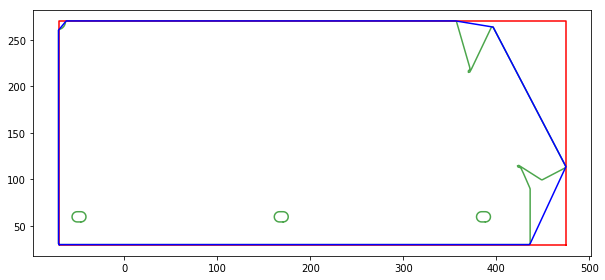

In [550]:
plot_dxf(details)

In [551]:
details['cut_length']

1731.1062423803512

# Plot a DXF

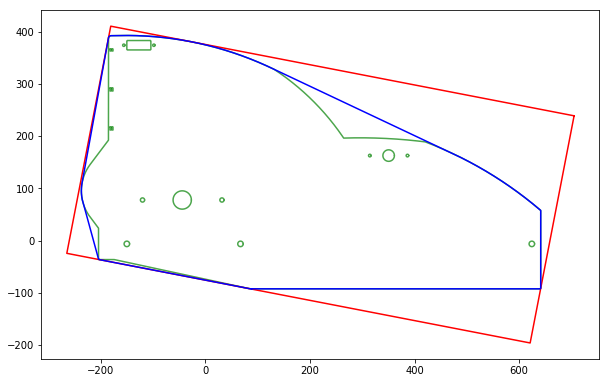

In [595]:
def plot_dxf(dxfdetails):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for closedsection in dxfdetails['closed_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='g', alpha=0.7, solid_capstyle='round')
    for opensection in dxfdetails['open_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='y', alpha=0.7, solid_capstyle='round')
    
    poly = Polygon(dxfdetails['minimum_rectangle_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='r')
    
    poly = Polygon(dxfdetails['convex_hull_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='b')
    
    ax.set_aspect('equal')
    
    plt.show()
    
plot_dxf(details)

In [574]:
details.keys()

dict_keys(['closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'num_closed_patterns', 'convex_hull_coords', 'convex_hull_area'])

# Dataset creation

In [599]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample', 'DXF')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]

columns = ['cut_length', 'num_closed_patterns', 'total_area', 'minimum_rectangle_area',
           'convex_hull_area', 'thickness', 'num_open_patterns']

dataset = pd.DataFrame(columns = columns)
dxfparser = DxfParser(min_edge_length=1)
for dxffile in dxflist:
    name = dxffile.split('/')[-1]
    name = name.split('.')[0]
    print(name)
    details = details = dxfparser.parse(dxffile)
    dataset.loc[name] = [details.get(x, np.nan) for x in dataset.columns]
dataset

K8035200_1 - copie
K8035200_1 2 - copie
K8035200_1 2
K8035200_1
k8035210_2 - copie
k8035210_2 2 - copie
k8035210_2 2
k8035210_2


,cut_length,num_closed_patterns,total_area,minimum_rectangle_area,convex_hull_area,thickness,num_open_patterns
K8035200_1 - copie,1731.106242,4.0,120315.642226,131257.064858,123075.895594,NaN,0.0
K8035200_1 2 - copie,1731.106242,4.0,120315.642226,131257.064858,123075.895594,NaN,0.0
K8035200_1 2,1731.106242,4.0,120315.642226,131257.064858,123075.895594,NaN,0.0
K8035200_1,1731.106242,4.0,120315.642226,131257.064858,123075.895594,NaN,0.0
k8035210_2 - copie,2972.871825,19.0,286987.547373,399813.350658,304531.562452,NaN,0.0
k8035210_2 2 - copie,2972.871825,19.0,286987.547373,399813.350658,304531.562452,NaN,0.0
k8035210_2 2,2972.871825,19.0,286987.547373,399813.350658,304531.562452,NaN,0.0
k8035210_2,2972.871825,19.0,286987.547373,399813.350658,304531.562452,NaN,0.0
